Практический проект по предсказанию рейтинга фильма.
Цель: В этом задании вам предстоит поработать с методом tf-idf чтобы извлечь признаки из текста для построения моделей.
1. Скачайте данные по отзывам с сайта IMDB (https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews), в которых для каждого отзыва поставлена семантическая оценка - "позитивный" или "негативный".

2. Разбейте данные на train/test, отложив 30% наблюдений для тестирования (датасет достаточно большой и выборка сбалансированная, так что можно не беспокоиться о стратификации)

3. Примените tf-idf преобразование. Используйте как отдельные токены, так и биграммы, отсейте английские стоп-слова, а также слова, которые встречаются реже, чем в двух отзывах, или чаще, чем в 50% отзывов (параметры min/max_df), не забудьте убрать l2 регуляризацию, которая по умолчанию включена

4. Постройте логистическую регрессию с настройкой параметра регуляризации, оцените качество при помощи метрик для бинарной классификации

5. Визуализируйте получившиеся коэффициенты регрессии (возьмите топ-50 слов). Какие слова наиболее характерны для отрицательных отзывов? Какие для положительных?
Критерии оценки: Предобработка текста в tf-idf - 6 баллов
Логит регрессия с оценкой качества - 2 балла
Визуализация коэффициентов - 2 балла

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import json

from sklearn.preprocessing import LabelEncoder


import seaborn as sn
from pylab import rcParams      
rcParams['figure.figsize'] = 8, 8
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [2]:
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

###  Часть 1. Описание набора данных и признаков

In [3]:
import zipfile
archive = zipfile.ZipFile('imdb-dataset-of-50k-movie-reviews.zip', 'r')
moviesfile = archive.open('IMDB Dataset.csv')

In [4]:
movies = pd.read_csv(moviesfile, index_col=False)

In [5]:
movies.shape

(50000, 2)

In [6]:
movies.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.3+ KB


In [8]:
movies['rating'] = True
movies['rating'] = movies['sentiment'] == 'positive'

In [9]:
movies.head(30).T

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
review,One of the other reviewers has mentioned that ...,A wonderful little production. <br /><br />The...,I thought this was a wonderful way to spend ti...,Basically there's a family where a little boy ...,"Petter Mattei's ""Love in the Time of Money"" is...","Probably my all-time favorite movie, a story o...",I sure would like to see a resurrection of a u...,"This show was an amazing, fresh & innovative i...",Encouraged by the positive comments about this...,If you like original gut wrenching laughter yo...,...,After the success of Die Hard and it's sequels...,I had the terrible misfortune of having to vie...,"What an absolutely stunning movie, if you have...","First of all, let's get a few things straight ...",This was the worst movie I saw at WorldFest an...,The Karen Carpenter Story shows a little more ...,"""The Cell"" is an exotic masterpiece, a dizzyin...",This film tried to be too many things all at o...,This movie was so frustrating. Everything seem...,'War movie' is a Hollywood genre that has been...
sentiment,positive,positive,positive,negative,positive,positive,positive,negative,negative,positive,...,positive,negative,positive,negative,negative,positive,positive,negative,negative,positive
rating,True,True,True,False,True,True,True,False,False,True,...,True,False,True,False,False,True,True,False,False,True


In [10]:
movies.tail(3)

,review,sentiment,rating
49997,I am a Catholic taught in parochial elementary...,negative,False
49998,I'm going to have to disagree with the previou...,negative,False
49999,No one expects the Star Trek movies to be high...,negative,False


In [11]:
movies.rating = movies.rating.apply(lambda x: 1 if x else -1)

In [12]:
import nltk
from nltk.corpus import stopwords

In [13]:
stop = stopwords.words('english')
stemmer = nltk.stem.snowball.EnglishStemmer('english')

def data_Stemmer(text):
    return ' '.join([stemmer.stem(word) for word in text.split(' ') if word not in stop])

In [14]:
data_Stemmer(movies.review[0])

"one review mention watch 1 oz episod hooked. they right, exact happen me.<br /><br />the first thing struck oz brutal unflinch scene violence, set right word go. trust me, show faint heart timid. this show pull punch regard drugs, sex violence. its hardcore, classic use word.<br /><br />it call oz nicknam given oswald maximum secur state penitentary. it focus main emerald city, experiment section prison cell glass front face inwards, privaci high agenda. em citi home many..aryans, muslims, gangstas, latinos, christians, italians, irish more....so scuffles, death stares, dodgi deal shadi agreement never far away.<br /><br />i would say main appeal show due fact goe show dare. forget pretti pictur paint mainstream audiences, forget charm, forget romance...oz mess around. the first episod i ever saw struck nasti surreal, i say i readi it, i watch more, i develop tast oz, got accustom high level graphic violence. not violence, injustic (crook guard who'll sold nickel, inmat who'll kill or

In [15]:
movies.review = movies.review.replace('<br /><br />', ' ')

In [16]:
movies.review = movies.review.apply(lambda x: data_Stemmer(x))

In [17]:
X = movies.review
y = movies.rating

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
#отсейте слова, которые встречаются реже, чем в двух отзывах, 
#или чаще, чем в 50% отзывов (параметры min/max_df)
tf_vectorizer = TfidfVectorizer(stop_words=stop, ngram_range=(1, 2), min_df=0.004, max_df = 0.5, norm=None)

In [19]:
Xtr, Xval, ytr, yval = train_test_split(X, y, test_size=0.30, random_state=42)

In [20]:
Xtr_tfidf = tf_vectorizer.fit_transform(Xtr)
Xval_tfidf = tf_vectorizer.transform(Xval)
Xtr_tfidf.shape, Xval_tfidf.shape

((35000, 4127), (15000, 4127))

In [21]:
from sklearn.linear_model import SGDClassifier, LogisticRegressionCV

In [22]:
logit_sgd = SGDClassifier(
    loss='log', 
    shuffle=True, 
    n_iter_no_change=10, 
    max_iter=500, 
    penalty='l2', 
    random_state=42
)

In [23]:
logit_sgd.fit(Xtr_tfidf, ytr)

print(accuracy_score(logit_sgd.predict(Xtr_tfidf), ytr))
print(accuracy_score(logit_sgd.predict(Xval_tfidf), yval))

print(classification_report(logit_sgd.predict(Xval_tfidf), yval))

0.9240571428571429
0.8618666666666667
              precision    recall  f1-score   support

          -1       0.87      0.85      0.86      7611
           1       0.85      0.87      0.86      7389

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



In [24]:
logit_cv = LogisticRegressionCV(Cs=10, n_jobs=-1)
logit_cv.fit(Xtr_tfidf, ytr)

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=-1, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [25]:
print(accuracy_score(logit_cv.predict(Xtr_tfidf), ytr))
print(accuracy_score(logit_cv.predict(Xval_tfidf), yval))
print(classification_report(logit_cv.predict(Xval_tfidf), yval))

0.9127714285714286
0.8876
              precision    recall  f1-score   support

          -1       0.87      0.90      0.88      7229
           1       0.90      0.88      0.89      7771

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000



In [26]:
result = pd.DataFrame(logit_sgd.coef_).T
result.columns = ['coeff']
result['word'] = tf_vectorizer.get_feature_names()
positive50 = result.sort_values(by=['coeff'],ascending=False)[0:50]
negative50 = result.sort_values(by=['coeff'],ascending=True)[0:50]



In [27]:
def visualize_coefficients(coef, feature_names, title, plot_num, n_top_features=50):
    
    interesting_coefficients = np.argsort(coef)[-n_top_features:]

    plt.figure(figsize=(15, 15))
    plt.subplot(510+plot_num+1)
    colors = ["lightblue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + n_top_features), 
               feature_names[interesting_coefficients], rotation=60, ha="right", fontsize=14);
    plt.title(title)

На графиках отображены по топ-50 слов, которые с весьма высокой вероятностью относят фильм  к negative или positive

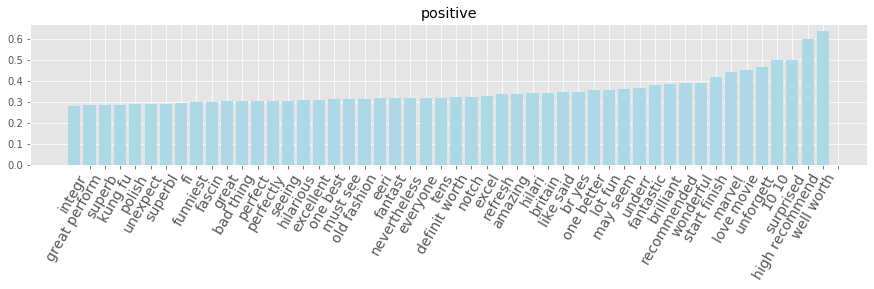

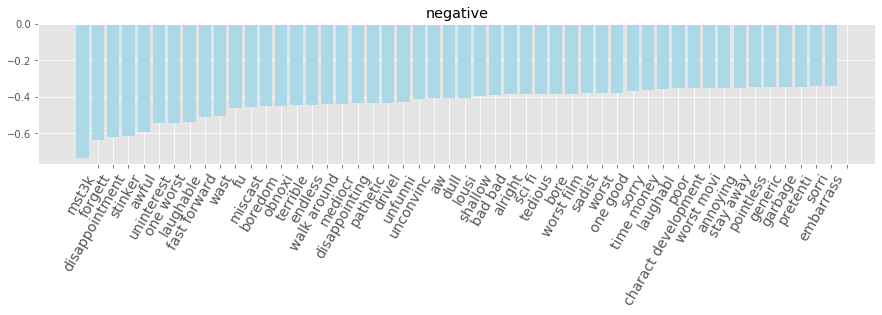

In [28]:
visualize_coefficients(np.array(positive50['coeff']), positive50['word'], title = 'positive', plot_num=0)
visualize_coefficients(np.array(negative50['coeff']), negative50['word'], title='negative', plot_num=0)